In [17]:
import pickle
import dgl
import torch
import numpy as np
import random
from scipy.spatial.distance import pdist

pickle_path_train_kmeans = '/home/nbiescas/Desktop/CVC/CVC_internship/PKL_Graphs/V2_Kmeans_dis_ntresh_discrete/train_Kmeans_dis_ntresh_discrete.pkl'
pickle_path_val_kmeans   = '/home/nbiescas/Desktop/CVC/CVC_internship/PKL_Graphs/V2_Kmeans_dis_ntresh_discrete/val_Kmeans_dis_ntresh_discrete.pkl'
pickle_path_test_kmeans  = '/home/nbiescas/Desktop/CVC/CVC_internship/PKL_Graphs/V2_Kmeans_dis_ntresh_discrete/test_Kmeans_dis_ntresh_discrete.pkl'
with open(pickle_path_train_kmeans, 'rb') as kmeans_train,\
        open(pickle_path_val_kmeans, 'rb')   as kmeans_val,\
        open(pickle_path_test_kmeans, 'rb')  as kmeans_test:

        train_graphs = pickle.load(kmeans_train)
        val_graphs = pickle.load(kmeans_val)
        test_graphs = pickle.load(kmeans_test)

In [21]:
import dgl
a, _ = dgl.load_graphs('/home/nbiescas/Desktop/CVC/CVC_internship/PKL_Graphs/GRAPHS_PEL_PAPER/test_nonContrastive_features.bin')

In [43]:
graph = '/home/nbiescas/Desktop/CVC/CVC_internship/PKL_Graphs/GRAPHS_PEL_PAPER/TEXT_AND_NODE_GEOM_CONTRAST/test_CONTRAST_geom_text.bin'
a, _ = dgl.load_graphs(graph)

import torch

In [37]:
torch.ceil_(torch.full((3, 3), 2.9, dtype=torch.float32))

tensor([[3., 3., 3.],
        [3., 3., 3.],
        [3., 3., 3.]])

In [30]:
import torch
torch.frac_(torch.full((3, 3), 0.5))

tensor([[0.5000, 0.5000, 0.5000],
        [0.5000, 0.5000, 0.5000],
        [0.5000, 0.5000, 0.5000]])

In [20]:
import torch
distances = torch.tensor([-32, 243, 343, 443])
torch.where(distances > 0.9)


(tensor([1, 2, 3]),)

In [3]:
a[0].edata['weights']

tensor([0.1000, 0.1000, 0.1000,  ..., 0.0000, 0.0000, 0.0000])

In [43]:
a[0].ndata['feat'].shape

torch.Size([103, 9])

In [11]:
d = train_graph[0].ndata
s = lambda x: (x, d[x].shape)
list(map(s, train_graph[0].ndata.keys()))

[('geom', torch.Size([27, 4])),
 ('feat', torch.Size([27, 4])),
 ('norm', torch.Size([27, 1])),
 ('label', torch.Size([27])),
 ('Geometric', torch.Size([27, 9])),
 ('area', torch.Size([27])),
 ('regional_encoding', torch.Size([27, 4]))]

In [33]:
import torch.nn as nn

layers_dimensions = [128, 64, 32, 16, 8, 4, 2]

layers = []
for i in range(len(layers_dimensions) - 1):
    layers.append(nn.Linear(layers_dimensions[i], layers_dimensions[i+1], bias=True))
    layers.append(nn.ReLU())

model = nn.Sequential(*layers)


Sequential(
  (0): Linear(in_features=128, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=32, bias=True)
  (3): ReLU()
  (4): Linear(in_features=32, out_features=16, bias=True)
  (5): ReLU()
  (6): Linear(in_features=16, out_features=8, bias=True)
  (7): ReLU()
  (8): Linear(in_features=8, out_features=4, bias=True)
  (9): ReLU()
  (10): Linear(in_features=4, out_features=2, bias=True)
  (11): ReLU()
)

In [65]:


def obtain_size(graph, nodes, edges):
    t = 9
    for n in nodes:
        if len(graph.ndata[n].shape) == 1:
            t += 1
        else:
            t += graph.ndata[n].shape[-1]
    for e in edges:
        if len(graph.edata[e].shape) == 1:
            t += 1
        else:
            t += graph.edata[e].shape[-1]
    return t

node = []
edge = ['distance_not_tresh', 'discrete_bin_edges', 'feat']
obtain_size(a[0], node, edge)

23

In [37]:
a, _  = dgl.load_graphs('/home/nbiescas/Desktop/CVC/CVC_internship/PKL_Graphs/Only_edgeFeatContra_TEXT/train_TEXT_only_edgeFeatContra.bin')

In [40]:
import torch

torch.load('/home/nbiescas/Desktop/CVC/CVC_internship/runs/run163_copia_run109/weights/model_0.pth')

NEW_contrastive_simplified(
  (dropout): Dropout(p=0.3, inplace=False)
  (encoder): ModuleList(
    (0): simplified_GCN_layer(
      (linear): Linear(in_features=15, out_features=15, bias=True)
      (lynorm): LayerNorm((15,), eps=1e-05, elementwise_affine=True)
    )
    (1): GraphConv(in=24, out=24, normalization=both, activation=<function relu at 0x7fe229755160>)
  )
  (final_projection): Sequential(
    (0): Linear(in_features=24, out_features=20, bias=True)
    (1): ReLU()
    (2): Linear(in_features=20, out_features=17, bias=True)
    (3): ReLU()
  )
)

In [1]:
import dgl
import torch
import pickle
from V2_contrastive_datasets import vector_func
from functools import partial
from utils import LoadConfig


/home/nbiescas/miniconda3/envs/doc2graph/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
pickle_path_train_kmeans = '/home/nbiescas/Desktop/CVC/CVC_internship/PKL_Graphs/V2_TEXT_Kmeans_dis_ntresh_discrete/train_TEXT_Kmeans_dis_ntresh_discrete.pkl'
pickle_path_val_kmeans = '/home/nbiescas/Desktop/CVC/CVC_internship/PKL_Graphs/V2_TEXT_Kmeans_dis_ntresh_discrete/val_TEXT_Kmeans_dis_ntresh_discrete.pkl'
pickle_path_test_kmeans = '/home/nbiescas/Desktop/CVC/CVC_internship/PKL_Graphs/V2_TEXT_Kmeans_dis_ntresh_discrete/test_TEXT_Kmeans_dis_ntresh_discrete.pkl'

with open(pickle_path_train_kmeans, 'rb') as f, open(pickle_path_val_kmeans, 'rb') as g, open(pickle_path_test_kmeans, 'rb') as h:
    train_graph = pickle.load(f)
    val_graph = pickle.load(g)
    test_graph = pickle.load(h)

In [13]:
path = '/home/nbiescas/Desktop/CVC/CVC_internship/PKL_Graphs/Only_edgeFeatContra_TEXT/train_TEXT_only_edgeFeatContra.bin'
graphs, _ = dgl.load_graphs(path)

In [41]:
import torch
weights_path = '/home/nbiescas/Desktop/CVC/CVC_internship/runs/run162_copia_run109/weights/model_132.pth'
model = torch.load(weights_path).to('cuda:0')

In [49]:
a, _ = dgl.load_graphs('/home/nbiescas/Desktop/CVC/CVC_internship/PKL_Graphs/GRAPHS_PEL_PAPER/MENYS_REGIONAL_ENCODING/val_NOTregional.bin')

In [51]:
a[0].ndata['feat'].shape

torch.Size([41, 317])

In [20]:

from src.models.all_models import MaskedGat_contrastive
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

config = LoadConfig('run144')
model_params = torch.load('/home/nbiescas/Desktop/CVC/CVC_internship/runs/run145/weights/epoch_1481.pth')
model = MaskedGat_contrastive(**config)
model.load_state_dict(model_params)
count_parameters(model)

23278051

In [54]:
import pickle
pickle_path_train_kmeans = '/home/nbiescas/Desktop/CVC/CVC_internship/PKL_Graphs/V2_TEXT_Kmeans_dis_ntresh_discrete/train_TEXT_Kmeans_dis_ntresh_discrete.pkl'
with open(pickle_path_train_kmeans, 'rb') as f:
    train_graph = pickle.load(f)

In [5]:
model = torch.load('/home/nbiescas/Desktop/CVC/CVC_internship/runs/run109/weights/model_71.pth').to('cuda:0')

pickle_path_train_kmeans = '/home/nbiescas/Desktop/CVC/CVC_internship/PKL_Graphs/V2_TEXT_Kmeans_dis_ntresh_discrete/train_TEXT_Kmeans_dis_ntresh_discrete.pkl'
pickle_path_val_kmeans = '/home/nbiescas/Desktop/CVC/CVC_internship/PKL_Graphs/V2_TEXT_Kmeans_dis_ntresh_discrete/val_TEXT_Kmeans_dis_ntresh_discrete.pkl'
pickle_path_test_kmeans = '/home/nbiescas/Desktop/CVC/CVC_internship/PKL_Graphs/V2_TEXT_Kmeans_dis_ntresh_discrete/test_TEXT_Kmeans_dis_ntresh_discrete.pkl'

with open(pickle_path_train_kmeans, 'rb') as f, open(pickle_path_val_kmeans, 'rb') as g, open(pickle_path_test_kmeans, 'rb') as h:
    train_graph = pickle.load(f)
    val_graph = pickle.load(g)
    test_graph = pickle.load(h)


In [6]:
config = LoadConfig('run109')
vector_func_partial = partial(vector_func, config) # Partial function to pass to apply_edges
def update_features(graphs: dgl.graph):
    batch = dgl.batch(graphs)
    batch.apply_edges(vector_func_partial)
    return batch

train_graphs = update_features(train_graph).to('cuda:0')
val_graphs = update_features(val_graph).to('cuda:0')
test_graphs = update_features(test_graph).to('cuda:0')

In [21]:
model.eval()
with torch.no_grad():
    train_embeddings = model(train_graphs)
    val_embeddings = model(val_graphs)
    test_embeddings = model(test_graphs)

train_graphs.ndata['feat'] = torch.cat((train_embeddings, train_graphs.ndata['text_feat']), dim=1)
val_graphs.ndata['feat'] = torch.cat((val_embeddings, val_graphs.ndata['text_feat']), dim=1)
test_graphs.ndata['feat'] = torch.cat((test_embeddings, test_graphs.ndata['text_feat']), dim=1)

dgl.save_graphs('/home/nbiescas/Desktop/CVC/CVC_internship/PKL_Graphs/Only_edgeFeatContra_TEXT/train_TEXT_only_edgeFeatContra.bin', dgl.unbatch(train_graphs))
dgl.save_graphs('/home/nbiescas/Desktop/CVC/CVC_internship/PKL_Graphs/Only_edgeFeatContra_TEXT/val_TEXT_only_edgeFeatContra.bin', dgl.unbatch(val_graphs))
dgl.save_graphs('/home/nbiescas/Desktop/CVC/CVC_internship/PKL_Graphs/Only_edgeFeatContra_TEXT/test_TEXT_only_edgeFeatContra.bin', dgl.unbatch(test_graphs))

In [7]:
import dgl
l, _ = dgl.load_graphs('/home/nbiescas/Desktop/CVC/CVC_internship/PKL_Graphs/Only_edgeFeatContra_TEXT/train_TEXT_only_edgeFeatContra.bin')

In [25]:
10 ** -4

0.0001

In [11]:
from torch import nn

RuntimeError: CUDA error: invalid device ordinal
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [5]:
l[0].ndata['feat'].shape

torch.Size([27, 317])

In [51]:
def vector_func(config, edges):
    node_feat_list = []
    for node_feat in config['features']['node']:
        node_feat = edges.src[node_feat]
        if len(node_feat.size()) == 1:
            node_feat = node_feat.unsqueeze(1)
        node_feat_list.append(node_feat)

    for edge_feat in config['features']['edge']:
        edge_feat = edges.data[edge_feat]
        if len(edge_feat.size()) == 1:
            edge_feat = edge_feat.unsqueeze(1)
        node_feat_list.append(edge_feat)
    
    msg = torch.cat(node_feat_list, dim=1)
    return {'m': msg}


train_graphs = [message_of_the_edges({'features': {'edge': ['feat', 'distance', 'angle'], 'node': ['Geometric']}}, graph) for graph in train_graph]


RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 103 but got size 1296 for tensor number 1 in the list.

In [44]:
torch.cat((train_graph[0].edata['feat'], train_graph[0].edata['distance'].unsqueeze(0)), dim = 1)

RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 1296 but got size 1 for tensor number 1 in the list.

In [38]:
train_graph[0].edata['distance'].unsqueeze(0)

torch.Size([1, 1296])

In [ ]:
def edge_feat(g, edge_feat):
    if g.edata[edge_feat]

In [34]:
config = {'features': {'edge': ['feat', 'distance', 'angle']}}
tuple(train_graph[0].edata[edge_feat] for edge_feat in config['features']['edge'] if train_graph[0].edata[edge_feat])

(tensor([[0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 1., 0., 1.],
         [0., 0., 0., 1., 0., 1.],
         ...,
         [1., 1., 0., 1., 0., 0.],
         [1., 1., 0., 0., 0., 0.],
         [1., 1., 0., 1., 0., 0.]]),
 tensor([0.1000, 0.1000, 0.1000,  ..., 0.0000, 0.0000, 0.0000]),
 tensor([-1.6057,  1.5359,  1.5010,  ...,  0.4538, -2.7227,  0.4189]))

In [22]:
dir(train_graph[0])

['__class__',
 '__contains__',
 '__copy__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_batch_num_edges',
 '_batch_num_nodes',
 '_canonical_etypes',
 '_dsttypes_invmap',
 '_edge_frames',
 '_etype2canonical',
 '_etypes',
 '_etypes_invmap',
 '_find_etypes',
 '_get_e_repr',
 '_get_n_repr',
 '_graph',
 '_idtype_str',
 '_init',
 '_is_unibipartite',
 '_node_frames',
 '_ntypes',
 '_pop_e_repr',
 '_pop_n_repr',
 '_reset_cached_info',
 '_set_e_repr',
 '_set_n_repr',
 '_srctypes_invmap',
 'add_edge',
 'add_edges',
 'add_nodes',
 'add_self_loop',
 'adj',
 'adj_sparse',
 'adjacency_matrix',
 'adjacency_matrix_scipy',
 'all_edges',
 'apply_edges',
 'apply_n

In [10]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(train_graph, test_size=0.2, random_state=42)

In [18]:
train_graph.__len__()

50

In [8]:
train_graph[0].ndata['norm'].shape
train_graph[0].ndata['norm'].min()

tensor(0.0196)

In [25]:
def get_encoding(coord):
    limit = 1 # High and with of the image after normalization
    return np.where(coord < limit / 2, np.where(coord < limit / 4, 11, 21), np.where(coord > limit / 4 * 3, 22, 12))

print(train_graph[0].ndata['geom'][0])
train_graph[0].ndata['geom'][0][0] = 0.51
get_encoding(train_graph[0].ndata['geom'])

tensor([0.5100, 0.1190, 0.1684, 0.1300])


array([[12, 11, 11, 11],
       [11, 11, 11, 11],
       [11, 11, 11, 11],
       [11, 11, 11, 21],
       [21, 21, 21, 21],
       [21, 21, 21, 21],
       [12, 21, 12, 21],
       [12, 21, 12, 21],
       [12, 21, 12, 21],
       [12, 11, 12, 11],
       [21, 21, 21, 21],
       [12, 21, 12, 21],
       [12, 21, 12, 21],
       [11, 12, 21, 12],
       [11, 22, 11, 22],
       [22, 11, 22, 11],
       [12, 11, 12, 11],
       [12, 11, 22, 11],
       [22, 11, 22, 11],
       [21, 11, 12, 11],
       [11, 11, 21, 11],
       [21, 11, 21, 11],
       [12, 21, 12, 21],
       [21, 21, 21, 21],
       [11, 21, 11, 21],
       [11, 21, 11, 12],
       [11, 12, 11, 12],
       [21, 21, 21, 21],
       [21, 21, 21, 21],
       [21, 21, 21, 12],
       [21, 21, 21, 21],
       [21, 21, 21, 12],
       [21, 12, 21, 12],
       [21, 12, 12, 12],
       [21, 21, 12, 21],
       [11, 12, 11, 12],
       [11, 12, 11, 12],
       [11, 12, 11, 12],
       [11, 12, 11, 12],
       [21, 12, 21, 12],


In [4]:
train_graph[0].ndata.keys()

dict_keys(['geom', 'feat', 'norm', 'label', 'Geometric'])

In [41]:
train_graph[0].edata['angle']

tensor([-0.0175,  3.1241,  0.1396,  ...,  0.5585, -2.7053,  0.4363])

In [33]:
train_graph[0].ndata['Geometric'][0][4].type()

'torch.FloatTensor'

### Emedding Visualization

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
import dgl

def extract_embeddings(loader, model):
    model = model.to('cuda:0')
    graph = dgl.batch(loader.graphs).to('cuda:0')
    h = graph.ndata['feat'].to('cuda:0')
    for layer in model.encoder:
        h = layer(graph, h)
    
    val_embeddings = h
    labels = graph.ndata['label']
    return val_embeddings.cpu().detach().numpy(), labels.cpu().detach().numpy()
    
val_embeddings, labels = extract_embeddings(test_data, model)

t_sne = TSNE(n_components = 2, perplexity=45, n_iter=1000, init="pca")    
S_t_sne = t_sne.fit_transform(val_embeddings)


/home/nbiescas/miniconda3/envs/doc2graph/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.

/home/nbiescas/miniconda3/envs/doc2graph/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



In [ ]:
fashion_mnist_classes = ["answer", "header", "other", "question"]
colors = ['#1f77b4', '#000000', '#2ca02c', '#d62728']

def plot_embeddings(embeddings, targets, xlim=None, ylim=None):
    plt.figure(figsize=(10,10))
    for i in range(4):
        inds = np.where(targets==i)[0]
        plt.scatter(embeddings[inds,0], embeddings[inds,1], alpha=0.5, color=colors[i], s=2)
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.ylim(ylim[0], ylim[1])
    plt.legend(fashion_mnist_classes)
    

In [1]:
from src.data.Dataset import FUNSD_loader
import torch
from src.models.all_models import MaskedGat_contrastive
from src.models.contrastive_models import class_contrastive_model
from utils import LoadConfig
import dgl 
from functools import partial
from src.training.utils import get_activation

/home/nbiescas/miniconda3/envs/doc2graph/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
Funsd_test = FUNSD_loader(train = True)

{   'FEATURES': {   'add_embs': True,
                    'add_eweights': True,
                    'add_fudge': False,
                    'add_geom': True,
                    'add_hist': False,
                    'add_visual': True,
                    'num_polar_bins': 8},
    'GRAPHS': {   'data_type': 'img',
                  'edge_type': 'knn',
                  'node_granularity': 'gt'},
    'LOADER': {   'src_data': 'FUNSD'}}


TRAIN


adding features: 100%|██████████| 149/149 [00:53<00:00,  2.81it/s]


In [25]:
import pickle 
path = '/home/nbiescas/Desktop/CVC/CVC_internship/PKL_Graphs/V2_TEXT_Kmeans_dis_ntresh_discrete/test_TEXT_Kmeans_dis_ntresh_discrete.pkl'
with open(path, 'rb') as f:
    test_graph = pickle.load(f)

In [29]:
Funsd_test.graphs[1]

Graph(num_nodes=48, num_edges=588,
      ndata_schemes={'geom_not_normalized': Scheme(shape=(4,), dtype=torch.float32), 'geom': Scheme(shape=(4,), dtype=torch.float32), 'feat': Scheme(shape=(1752,), dtype=torch.float32), 'norm': Scheme(shape=(1,), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={'feat': Scheme(shape=(6,), dtype=torch.float32), 'distance_not_tresh': Scheme(shape=(), dtype=torch.float32), 'weights': Scheme(shape=(), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.int64)})

In [40]:
test_graph[25].ndata['text_feat'] == Funsd_test.graphs[1].ndata['feat'][:, 4:304]

tensor([[False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        ...,
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False]])

In [47]:
Funsd_test.graphs[1].ndata['feat'][:, :4].shape

torch.Size([48, 4])

In [81]:
Funsd_test.graphs[1].ndata['feat'][:, 304:].shape

torch.Size([48, 1448])

In [51]:
Funsd_test.graphs[1].ndata['feat'][:, 3:304][:, 0] == Funsd_test.graphs[1].ndata['feat'][:, 4:][:, -1]

tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False])

In [44]:
Funsd_test.graphs[1].ndata['feat'][:, 4:304].shape

torch.Size([48, 300])

In [16]:
Funsd_test.graphs[0].ndata['feat'].shape

torch.Size([104, 1752])

In [20]:
Funsd_test.graphs[0].ndata['feat'][:, :4].shape

torch.Size([104, 4])

In [15]:
Funsd_test.graphs[0].ndata['feat'][:, 304:].shape

torch.Size([104, 1448])

In [1]:
import dgl
a, b = dgl.load_graphs('/home/nbiescas/Desktop/CVC/CVC_internship/PKL_Graphs/VISUAL/VISUAL_AMB_GEOM/val_visual_geom.bin')

/home/nbiescas/miniconda3/envs/doc2graph/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import torch.nn as nn
import torch
class multimodal_attention(nn.Module):
    """
    dot-product attention mechanism
    """
    def __init__(self, attention_dropout=0.5):
        super(multimodal_attention, self).__init__()
        self.dropout = nn.Dropout(attention_dropout)
        self.softmax = nn.Softmax(dim=2)

    def forward(self, q, k, v, scale=None, attn_mask=None):
       
        attention = torch.matmul(q, k.transpose(-2, -1))
        #print('attention.shape:{}'.format(attention.shape))
        if scale:
            attention = attention * scale

        if attn_mask:
            attention = attention.masked_fill_(attn_mask, -np.inf)
        attention = self.softmax(attention)
        #print('attention.shftmax:{}'.format(attention))
        attention = self.dropout(attention)
        attention = torch.matmul(attention, v)
        #print('attn_final.shape:{}'.format(attention.shape))

        return attention

class PositionalWiseFeedForward(nn.Module):
    """
    Fully-connected network 
    """
    def __init__(self, model_dim=256, ffn_dim=2048, dropout=0.5):
        super(PositionalWiseFeedForward, self).__init__()
        self.w1 = nn.Linear(model_dim, ffn_dim)
        self.w2 = nn.Linear(ffn_dim, model_dim)
        
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(model_dim)

    def forward(self, x):
        residual = x

        x = self.w2(F.relu(self.w1(x)))
        x = self.dropout(x)
        x += residual

        x = self.layer_norm(x)
        output = x
        return output
    
class MultiHeadAttention(nn.Module):
    def __init__(self, model_dim=256, num_heads=8, dropout=0.5):
        super(MultiHeadAttention, self).__init__()
        
        self.model_dim = model_dim
        self.dim_per_head = model_dim // num_heads
        self.num_heads = num_heads
        self.linear_k = nn.Linear(1, self.dim_per_head * num_heads, bias=False)
        self.linear_v = nn.Linear(1, self.dim_per_head * num_heads, bias=False)
        self.linear_q = nn.Linear(1, self.dim_per_head * num_heads, bias=False)

        self.dot_product_attention = multimodal_attention(dropout)
        self.linear_final = nn.Linear(model_dim, 1, bias=False)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(model_dim)

    def forward(self, query, key, value, attn_mask=None):
        residual = query
        query = query.unsqueeze(-1)
        key = key.unsqueeze(-1)
        value = value.unsqueeze(-1)
        #print("query.shape:{}".format(query.shape))

        dim_per_head = self.dim_per_head
        num_heads = self.num_heads
        #batch_size = key.size(0)

        # linear projection
        key = self.linear_k(key)
        value = self.linear_v(value)
        query = self.linear_q(query)
        #print('key.shape:{}'.format(key.shape))

        # split by heads
        key = key.view(-1, num_heads, self.model_dim, dim_per_head)
        value = value.view(-1, num_heads, self.model_dim, dim_per_head)
        query = query.view(-1, num_heads, self.model_dim, dim_per_head)

        # scaled dot product attention
        scale = (key.size(-1) // num_heads)**-0.5
        attention = self.dot_product_attention(query, key, value, 
                                               scale, attn_mask)

        attention = attention.view(-1, self.model_dim, dim_per_head * num_heads)
        #print('attention_con_shape:{}'.format(attention.shape))

        # final linear projection
        output = self.linear_final(attention).squeeze(-1)
        #print('output.shape:{}'.format(output.shape))
        # dropout
        output = self.dropout(output)
        # add residual and norm layer
        output = self.layer_norm(residual + output)

        return output
    
class multimodal_fusion_layer(nn.Module):
    """
    A layer of fusing features 
    """
    def __init__(self, model_dim=256, num_heads=8, ffn_dim=2048, dropout=0.5):
        super(multimodal_fusion_layer, self).__init__()
        self.attention_1 = MultiHeadAttention(model_dim, num_heads, dropout)
        self.attention_2 = MultiHeadAttention(model_dim, num_heads, dropout)
        
        self.feed_forward_1 = PositionalWiseFeedForward(model_dim, ffn_dim, dropout)
        self.feed_forward_2 = PositionalWiseFeedForward(model_dim, ffn_dim, dropout)
        
        self.fusion_linear = nn.Linear(model_dim*2, model_dim)

    def forward(self, image_output, text_output, attn_mask=None):

        output_1 = self.attention_1(image_output, text_output, text_output,
                                 attn_mask)
        
        output_2 = self.attention_2(text_output, image_output, image_output,
                                 attn_mask)
        
        
        #print('attention out_shape:{}'.format(output.shape))
        output_1 = self.feed_forward_1(output_1)
        output_2 = self.feed_forward_2(output_2)
        
        output = torch.cat([output_1, output_2], dim=1)
        output = self.fusion_linear(output)

        return output
    


In [3]:
# Load the model
weights = '/home/nbiescas/Desktop/CVC/CVC_internship/runs/run151/weights/epoch_1149.pth'
config = LoadConfig('run151')
config['activation'] = get_activation(config['activation'])
model_finetuning = MaskedGat_contrastive(**config)
model_finetuning.load_state_dict(torch.load(weights))
model_finetuning = model_finetuning.to('cuda:0')

In [1]:
import dgl

a, b = dgl.load_graphs('/home/nbiescas/Desktop/CVC/CVC_internship/PKL_Graphs/WEIGHTED_CONCAT/train_text_geom_weighted.bin')

/home/nbiescas/miniconda3/envs/doc2graph/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


DGLError: File /home/nbiescas/Desktop/CVC/CVC_internship/PKL_Graphs/WEIGHTED_CONCAT/train_text_geom_weighted.bin does not exist.

In [4]:
from src.training.masking import add_features
from src.training.utils import weighted_edges, discrete_bin_edges

def vector_func(config, edges):
    node_feat_list = []
    for node_feat in config['features']['node']:
        node_feat = edges.src[node_feat]
        if len(node_feat.size()) == 1:
            node_feat = node_feat.unsqueeze(1)
        node_feat_list.append(node_feat)

    for edge_feat in config['features']['edge']:
        edge_feat = edges.data[edge_feat]
        if len(edge_feat.size()) == 1:
            edge_feat = edge_feat.unsqueeze(1)
        node_feat_list.append(edge_feat)
    
    msg = torch.cat(node_feat_list, dim=1)
    return {'m': msg}

def prepare_graphs(graph):
    # Prepare the graphs
    geometric = add_features(graph)
    graph.ndata['area'] = geometric[:, 4]
    graph.ndata['regional_encoding'] = geometric[:, 5:]
    graph.ndata['text_feat'] = graph.ndata['feat'][:, 4:]
    graph.ndata['Geometric'] = geometric # bounding box, area and region encoding

    # Distance between nodes
    graph.edata['angle'] = weighted_edges(graph) 
    graph.edata['distance_normalized'] = graph.edata['weights']
    graph.edata['discrete_bin_edges'] = discrete_bin_edges(graph)
    return graph

In [5]:
#pretrain_model = class_contrastive_model(**config_pretrain).to('cuda:0')
# Load the pretrain weights
weights_pretrain = '/home/nbiescas/Desktop/CVC/CVC_internship/runs/run109/weights/model_71.pth'
pretrain_model = torch.load(weights_pretrain).to('cuda:0')

In [6]:
# Prepare the graphs
config_pretrain = LoadConfig('run109')
message_func = partial(vector_func, config_pretrain)
graphs_pretrain = [prepare_graphs(graph) for graph in Funsd_test.graphs]
graphs = dgl.batch(graphs_pretrain).to('cuda:0')
graphs.apply_edges(message_func)

In [101]:
Funsd_test.graphs[0].ndata['label']

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 3, 3, 3, 0, 0,
        0, 0, 3, 0, 0, 0, 0, 0, 0, 3, 3, 3, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        2, 0, 0, 0, 3, 0, 0, 0, 2, 3, 3, 3, 0, 0, 0, 3, 3, 3, 0, 0, 3, 3, 3, 2,
        3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 3, 3, 3, 3, 3, 3, 0,
        0, 0, 0, 0, 0, 2, 2])

In [7]:
# Obtain the embeddings
pretrain_model.eval()
model_finetuning.eval()
with torch.no_grad():
    embeddings = pretrain_model(graphs)
    graphs.ndata['feat'] = torch.cat((embeddings, graphs.ndata['text_feat']), dim=1)
    x_pred_nodes, x_pred_edges = model_finetuning(graphs, graphs.ndata['feat'])

    graphs.ndata['label'] = x_pred_nodes.argmax(axis=1)
    graphs.edata['label'] = x_pred_edges.argmax(axis=1)

    graphs_with_predicitons = dgl.unbatch(graphs)

In [8]:
(graphs.edata['label'] == 1).sum()

tensor(1547, device='cuda:0')

In [9]:
(graphs_with_predicitons[3].edata['label'] == 1).sum()


tensor(94, device='cuda:0')

In [149]:
#'question': a dark orange color (150, 75, 0)
#'answer': a dark green color (0, 100, 0)
#'other': a gray color (128, 128, 128)
#'header': a magenta color (255, 0, 255)

50

In [ ]:
num_graph = 16
num_graph = 18

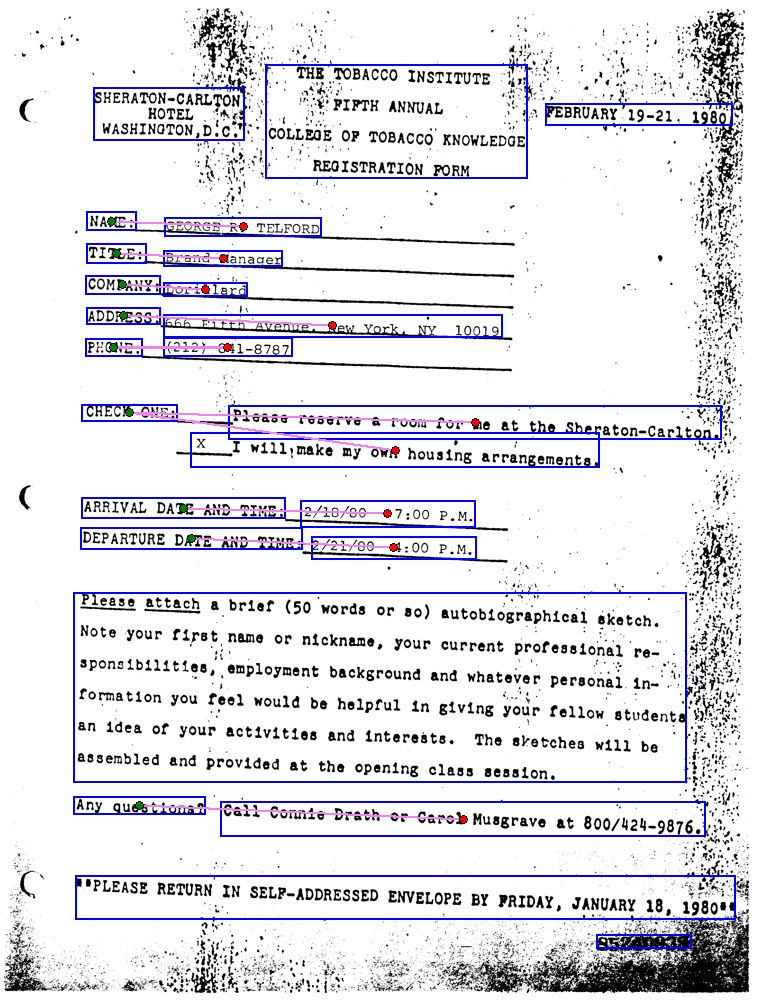

In [49]:
num_graph = 19
Funsd_test.print_graph(num = num_graph)

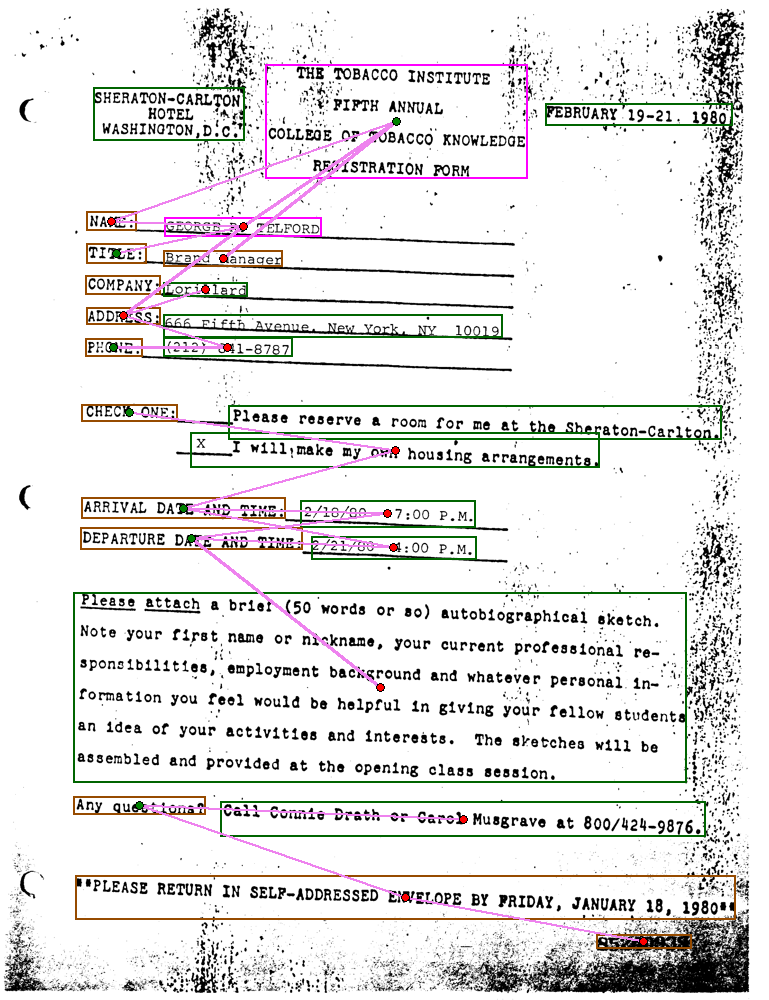

In [50]:
num_graph = 19
Funsd_test.print_graph(num = num_graph, 
                       node_labels=graphs_with_predicitons[num_graph].ndata['label'],
                       labels_ids=graphs_with_predicitons[num_graph].edata['label'].nonzero().flatten().tolist())